<a href="https://colab.research.google.com/github/Laura9704/Fundamentos_MCD/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#libreria

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #gráficos
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense # Se usa SimpleRNN o la capa RNN que elijas
from tensorflow.keras.optimizers import Adam

# Importa librerías para imputación
from scipy.interpolate import interp1d

import random
import os
import warnings
warnings.filterwarnings('ignore')

## Cargar desde Kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"svlauracarolinasv","key":"2d7513d4cd31b4367dc2a650087afced"}'}

In [3]:
import sys
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
import zipfile
# --- PASO 1: Descargar y Descomprimir ---
competition_name = 'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn'
zip_file_name = f'{competition_name}.zip'

print(f"1. Descargando datos de la competición: {competition_name}...")
# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.
!kaggle competitions download -c {competition_name} -p /content/

# Descomprimir el archivo ZIP
print(f"2. Descomprimiendo archivos...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extraer todo el contenido a la carpeta actual (/content/)
        zip_ref.extractall('/content/')
    print("Descompresión completada. Archivos Parquet listos.")
except FileNotFoundError:
    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")
    print("Asegúrate de que la descarga fue exitosa.")
    exit()

# --- PASO 2: Cargar df_train y df_test usando pd.read_parquet ---
try:
    # Cargar el set de entrenamiento
    df_train = pd.read_parquet('df_train.parquet')
    print(f"\n3. df_train cargado (Parquet). Shape: {df_train.shape}")

    # Cargar el set de prueba (test)
    df_test = pd.read_parquet('df_test.parquet')
    print(f"   df_test cargado (Parquet). Shape: {df_test.shape}")

except Exception as e:
    print("\n[ERROR] No se pudieron cargar 'df_train.parquet' o 'df_test.parquet'.")
    print(f"Detalle del error: {e}")

1. Descargando datos de la competición: fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn...
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 194MB/s]
2. Descomprimiendo archivos...
Descompresión completada. Archivos Parquet listos.

3. df_train cargado (Parquet). Shape: (8932, 10)
   df_test cargado (Parquet). Shape: (184, 9)


In [ ]:
df_train.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
0,2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0
1,2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0
2,2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1
3,2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0
4,2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0


In [ ]:
df_train.isnull().sum()

,0
date,0
min_temp,56
avg_temp,57
max_temp,54
min_rel_humidity,94
avg_rel_humidity,92
max_rel_humidity,51
solar_radiation,88
evapotranspiration,1000
precipitation,0


In [ ]:
df_test.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration
0,2024-07-01,17.4,23.4,31.1,49.0,83.0,100.0,529.7,4.3
1,2024-07-02,20.2,23.7,29.8,61.0,85.0,100.0,396.5,3.3
2,2024-07-03,20.9,23.7,30.1,55.0,86.0,100.0,359.3,3.0
3,2024-07-04,19.5,22.7,28.9,63.0,91.0,100.0,304.8,2.4
4,2024-07-05,18.8,20.8,24.4,76.0,96.0,100.0,241.0,1.9


In [ ]:
df_test.isnull().sum()

,0
date,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0


In [5]:
df=df_train.copy()

## CARGA DE ARCHIVOS DESDE DRIVE

In [ ]:
'''
# CARGAR df_train.parquet
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'
df = pd.read_parquet(file_path)
'''

# Imputacion del DATA

Diferencias entre imputación por media estacional e interpolación

**1. Imputación por estacionaliladad**

  *  **Qué hace:** Reemplaza valores faltantes con el promedio de valores observados en la misma estación/período (por ejemplo, todos los eneros, o todos los lunes, o la misma semana del año)
  *  **Supuesto:** Los datos tienen patrones estacionales recurrentes y el valor faltante debería parecerse al comportamiento típico de ese período
  *  **Resultado:** Introduce un valor "promedio" o "típico" que no considera la tendencia local ni los valores inmediatamente adyacentes
  *  **Ventaja:** Preserva patrones estacionales y es útil cuando hay ciclos claros (temperatura, ventas navideñas)
  *  **Desventaja:** Ignora la continuidad temporal local; puede crear saltos bruscos si el período actual es atípico

**2. Interpolación**

  *  **Qué hace:** Estima valores faltantes basándose en los valores observados más cercanos en el tiempo (anterior y posterior)
  *  **Supuesto:** Existe continuidad temporal y el valor faltante debería ser una transición suave entre sus vecinos
  *  **Métodos comunes:** Lineal (línea recta entre puntos), spline (curva suave), polinomial y time
  *  **Resultado:** Crea una transición continua que respeta la tendencia local
  *  **Ventaja:** Mantiene la continuidad de la serie y refleja mejor cambios graduales o tendencias
  *  **Desventaja:** No considera patrones estacionales; puede fallar si hay cambios abruptos reales



##Forma 1: Combinadondo
en esta imputacion toma en cuanta el largo de los huecos dentro de las variables del Data, que son mayores a 4 toma el de estacionalidad.

In [6]:
# -------------------------------
# FUNCIONES
# -------------------------------

def mask_long_nan_blocks(series, min_len=4):
    """
    Devuelve una máscara booleana para los NaN consecutivos con longitud mínima `min_len`.
    """
    is_nan = series.isna()
    mask = pd.Series(False, index=series.index)
    count = 0
    for i in range(len(series)):
        if is_nan.iloc[i]:
            count += 1
        else:
            if count >= min_len:
                mask.iloc[i - count:i] = True
            count = 0
    # Para el final de la serie
    if count >= min_len:
        mask.iloc[len(series) - count:] = True
    return mask

# -------------------------------
# Index de dates
# -------------------------------

df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# -------------------------------
# VARIABLES A PROCESAR
# -------------------------------

columns_to_process = [
    'avg_temp', 'max_temp', 'min_temp',
    'avg_rel_humidity', 'max_rel_humidity', 'min_rel_humidity',
    'solar_radiation', 'evapotranspiration'
]

# Crear columna auxiliar: día del año (1-365)
df['dayofyear'] = df.index.dayofyear

# Definir un umbral superior basado en el conocimiento del dominio.
# Si 6999 es claramente un error, podemos usar un umbral conservador (e.g., 20)
UMBRAL_SUPERIOR = 20

# Reemplazar el valor atípico (outlier) con NaN
# Esto es esencial antes de la imputación estacional
df.loc[df['evapotranspiration'] > UMBRAL_SUPERIOR, 'evapotranspiration'] = None # Usamos 'None' o np.nan

print(f"Valores de evapotranspiration > {UMBRAL_SUPERIOR} han sido convertidos a NaN.")

# -------------------------------
# IMPUTACIÓN HÍBRIDA
# -------------------------------

for col in columns_to_process:
    series = df[col].copy()

    # 1. Identificar bloques largos
    long_nan_mask = mask_long_nan_blocks(series, min_len=4)

    # 2. Interpolación para bloques cortos
    series[~long_nan_mask] = series[~long_nan_mask].interpolate(limit=3, limit_direction='both')

    # 3. Estacionalidad por día del año para los valores restantes
    if series.isna().sum() > 0:
        series = series.fillna(df.groupby('dayofyear')[col].transform('mean'))

    # Reasignar al DataFrame original
    df[col] = series

# Eliminar columna auxiliar
df.drop(columns='dayofyear', inplace=True)

# -------------------------------
# REVISIÓN FINAL
# -------------------------------

print("Valores faltantes después de imputación:")
print(df[columns_to_process].isna().sum())


Valores de evapotranspiration > 20 han sido convertidos a NaN.
Valores faltantes después de imputación:
avg_temp              0
max_temp              0
min_temp              0
avg_rel_humidity      0
max_rel_humidity      0
min_rel_humidity      0
solar_radiation       0
evapotranspiration    0
dtype: int64


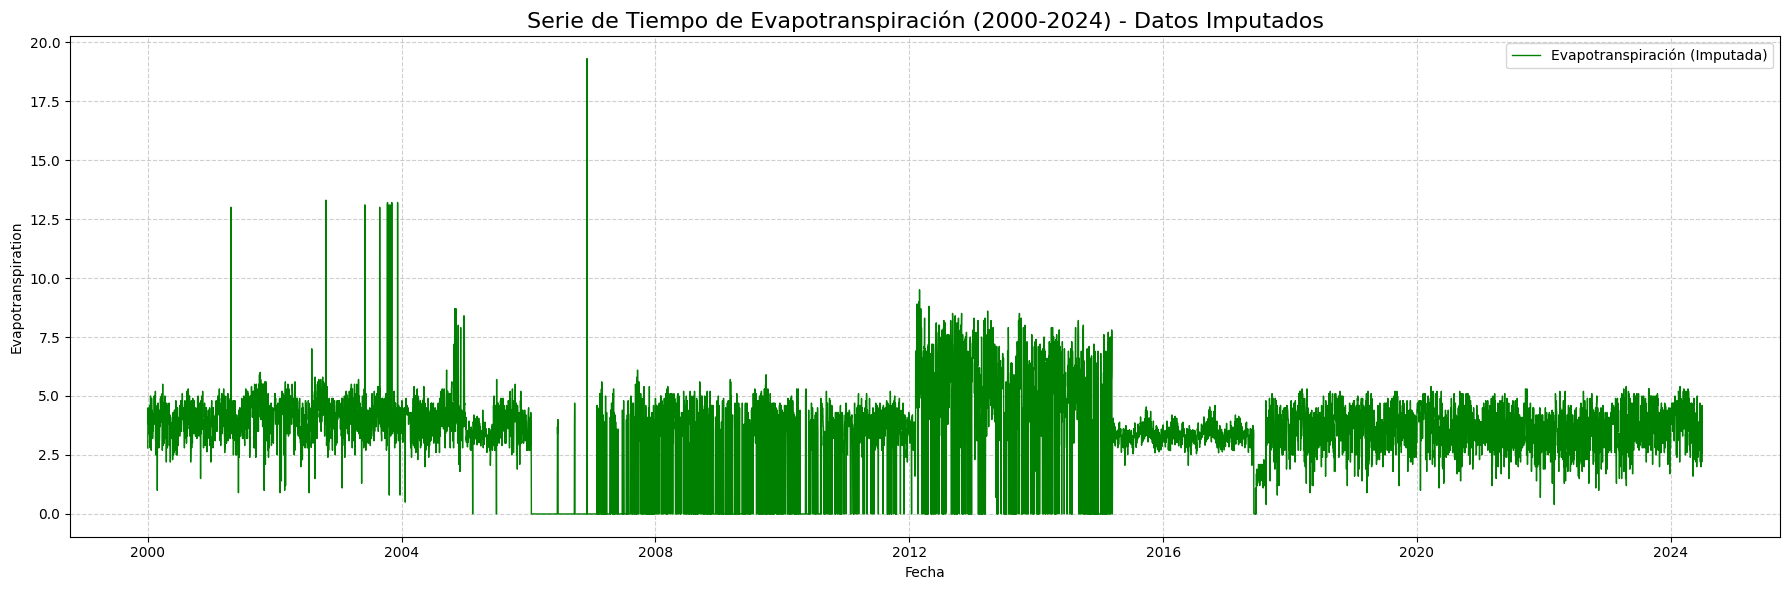


--- Verificación en la Brecha (2015-2018) ---


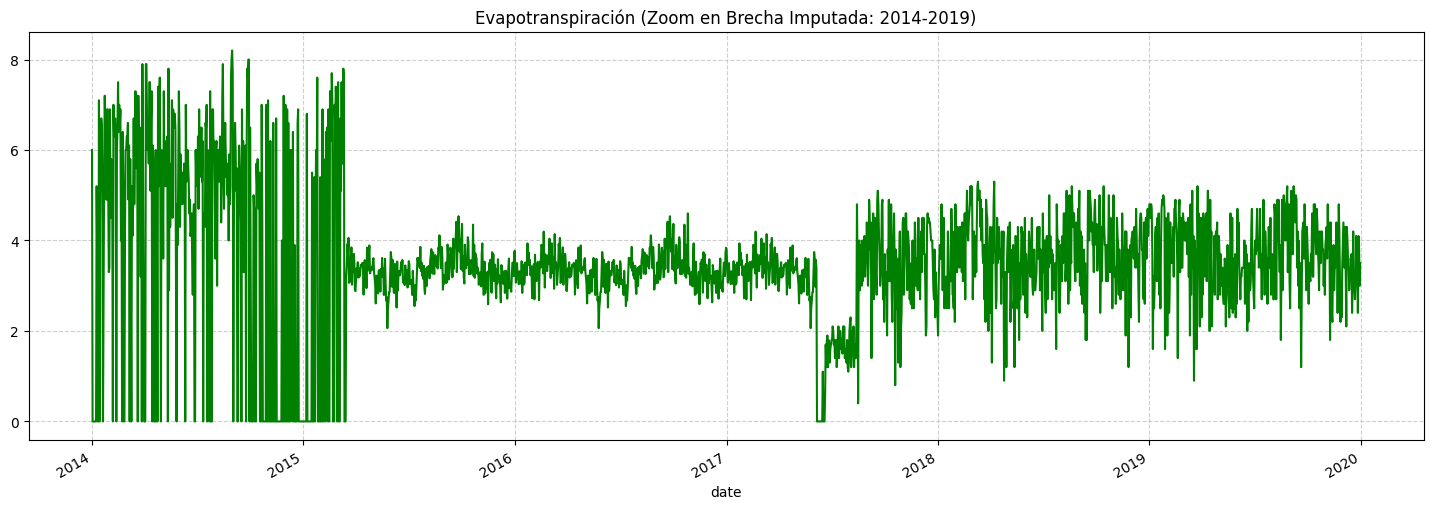

In [7]:
df_imputado=df.copy()
df=df_train.copy()
if not isinstance(df_imputado.index, pd.DatetimeIndex):
    # Esto es solo una verificación de seguridad si el índice no está configurado
    if 'date' in df_imputado.columns:
        df_imputado = df_imputado.set_index('date')
    df_imputado.index = pd.to_datetime(df_imputado.index)

# 2. Generar el gráfico
plt.figure(figsize=(18, 6))

# Grafica la serie completa. Ahora no habrá saltos ni NaN.
plt.plot(df_imputado.index,
         df_imputado['evapotranspiration'],
         color='green', # Usamos un color distinto para diferenciar de los gráficos originales
         linewidth=1.0,
         label='Evapotranspiración (Imputada)')

# 3. Formato y Título
plt.title("Serie de Tiempo de Evapotranspiración (2000-2024) - Datos Imputados", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. (Opcional) Zoom para verificar la imputación en la zona 2015-2018
print("\n--- Verificación en la Brecha (2015-2018) ---")
plt.figure(figsize=(18, 6))
df_imputado.loc['2014':'2019', 'evapotranspiration'].plot(
    color='green', linewidth=1.5,
    title='Evapotranspiración (Zoom en Brecha Imputada: 2014-2019)'
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Definir las fechas límite
start_date = '2015-04-16'
end_date = '2015-04-20'

# 1. Asegúrate de que la columna 'date' sea de tipo datetime
# df_train['date'] = pd.to_datetime(df_train['date'])

# 2. Filtrar usando la columna 'date'
df_periodo = df_train[
    (df_train['date'] >= start_date) &
    (df_train['date'] <= end_date)
].copy()
df_periodo

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
5568,2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,NaN,1.8
5569,2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,NaN,9.7
5570,2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,NaN,0.0
5571,2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,NaN,38.4
5572,2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,NaN,28.8


In [ ]:
df_imputado = df_imputado.round(1)
df_imputado.loc['2015-04-16':'2015-04-20']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
date,,,,,,,,,
2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,3.4,1.8
2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,3.6,9.7
2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,3.0,0.0
2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,3.5,38.4
2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,2.9,28.8


#Simple RNN

In [9]:

# 1️⃣ Copiar y asegurar formato temporal
df_e = df_imputado.copy()  # reemplaza con tu variable real
df_e.index = pd.to_datetime(df_e.index)
df_e = df_e.sort_index()

# 2️⃣ Filtrar las fechas de entrenamiento y validación
train_df = df_e.loc['2000-01-01':'2023-12-31']
val_df = df_e.loc['2024-01-01':'2024-06-30']

# 3️⃣ Escalar con datos de entrenamiento para evitar fuga de información
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)

train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
'''
n_steps = 12  # ventana de tiempo (puedes ajustar)

X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
'''



Entrenamiento: (8738, 12, 9) (8738,)
Validación: (170, 12, 9) (170,)


## Parámetros


Se implementó una red neuronal recurrente (RNN) utilizando la clase SimpleRNN de Keras, con el objetivo de pronosticar la precipitación diaria a partir de variables climáticas históricas. El conjunto de entrenamiento abarcó el período 01/01/2000–31/12/2023, mientras que los datos de 2024 se destinaron exclusivamente a validación. Para evitar fuga de información, el escalado se realizó únicamente sobre los datos de entrenamiento.

In [24]:
# ===============================================================
# SECCIÓN DE PARÁMETROS AJUSTABLES
# ===============================================================

target_col = 'precipitation'   # Variable objetivo
lookbacks = [5, 6, 7, 14, 21, 24, 30, 36]  # Ventanas temporales a probar

# Hiperparámetros del modelo
params = {
    'units': 128,         # Número de neuronas en la capa RNN
    'lr': 0.005,          # Tasa de aprendizaje
    'batch_size': 16,     # Tamaño de lote
    'epochs': 50,         # Número de épocas
    'drop_rate': 0.2      # Dropout para regularización
}

Se realizaron múltiples análisis con diferentes valores de lookback con el objetivo de identificar la ventana temporal que ofrece el mejor desempeño del modelo presentado a continuación. De acuerdo con los hallazgos del análisis exploratorio (EDA), se consideró que las ventanas cortas (entre 5 y 7 días) son más informativas y sensibles para capturar la variabilidad reciente de las precipitaciones. Cabe aclarar que en esta etapa se utilizaron únicamente las variables originales del conjunto de datos, previamente imputadas. Por tanto, esta sección busca determinar la longitud de ventana más adecuada para optimizar la capacidad predictiva del modelo RNN.

con respecto a los hirperparametros se seleccion como uma opcion que permite evaluar el comportamiento inicial de la red y servirán como referencia para futuros ajustes en busca de un mejor rendimiento

 * Número de neuronas: se seleccionó un valor intermedio que permita al modelo capturar patrones temporales sin que el número de parámetros sea excesivo para una primera iteración.

 * Tasa de aprendizaje: se seleccionó una tasa ligeramente superior al valor comúnmente utilizado (0.001) con el objetivo de acelerar la convergencia inicial y observar cómo responde el modelo a los primeros ajustes. Esta decisión permite evaluar si un aprendizaje más rápido mejora el desempeño sin comprometer la estabilidad del entrenamiento.

* Tamaño de lote: se definió un lote pequeño para mantener una actualización frecuente de los pesos y mejorar la estabilidad durante el entrenamiento inicial.

* Número de épocas: se estableció un número suficiente para analizar la tendencia del error sin extender innecesariamente el tiempo de cómputo.

* Dropout: se aplicó una regularización básica para prevenir sobreajuste y observar cómo el modelo generaliza desde las primeras pruebas.

In [33]:
# ===============================================================
# Función para crear secuencias multivariables
# ===============================================================
def create_multivariate_sequences(data, target_col, n_steps=12):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].values)
        y.append(data[target_col].iloc[i+n_steps])
    return np.array(X), np.array(y)
# ===============================================================
# Función para entrenar y evaluar el modelo RNN
# ===============================================================
def train_rnn(
    X_train,
    y_train,
    X_val, y_val,
    n_steps,
    n_features,
    units=64,
    lr=0.001,
    batch_size=16,
    epochs=50,
    drop_rate=0.2):

    # Definición del modelo
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=(n_steps, n_features)),
        Dropout(drop_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mae',
        metrics=['mse']
    )

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0
    )

    #  Evaluación
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred


Para evaluar el desempeño del modelo RNN en la predicción de precipitaciones diarias, se decidio implementar diversas métricas que permiten analizar tanto la precisión como la estabilidad del modelo desde diferentes perspectivas:

* Error cuadrático medio (MSE): mide el promedio del cuadrado de los errores entre los valores reales y los predichos. Penaliza fuertemente los errores grandes, por lo que es útil para identificar desviaciones significativas en las predicciones.

* Error absoluto medio (MAE): calcula la magnitud promedio de los errores sin considerar su dirección. Es más interpretable que el MSE, ya que refleja directamente la desviación media del modelo respecto a los valores reales.

* Raíz del error cuadrático medio (RMSE): se obtiene al aplicar la raíz cuadrada del MSE. Esta métrica tiene las mismas unidades que la variable objetivo (precipitación), lo que facilita la interpretación física de los resultados.

* Coeficiente de determinación (R²): cuantifica la proporción de la variabilidad de los datos reales que es explicada por el modelo. Un valor cercano a 1 indica un buen ajuste y capacidad predictiva.

In [34]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")



Entrenando con lookback = 5 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5 →→ RMSE=0.088851, MSE=0.007895, MAE=0.032545, R²=-0.1550
Entrenando con lookback = 6 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6 →→ RMSE=0.088669, MSE=0.007862, MAE=0.032764, R²=-0.1447
Entrenando con lookback = 7 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7 →→ RMSE=0.089111, MSE=0.007941, MAE=0.032827, R²=-0.1506
Entrenando con lookback = 14 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
14 →→ RMSE=0.091167, MSE=0.008311, MAE=0.034051, R²=-0.1621
Entrenando con lookback = 21 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
21 →→ RMSE=0.091670, MSE=0.008403, MAE=0.036321, R²=-0.1340
Entrenando con lookback = 24 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
24 →→ RMSE=0.093662, MSE=0.008773, MAE=0.036172, R²=-0.1654
Entrenando con lookback = 30 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
30 →→ RMSE=0.094592, MSE=0.008948, MAE=0.037427, R²=-0.1856
Entrenando con lookback = 36 días...
5/5 ━━━━━━━━━━━━━━━━━━━━


Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.007895  0.032545  0.088851 -0.154952
1         6  0.007862  0.032764  0.088669 -0.144727
2         7  0.007941  0.032827  0.089111 -0.150601
3        14  0.008311  0.034051  0.091167 -0.162118
4        21  0.008403  0.036321  0.091670 -0.133952
5        24  0.008773  0.036172  0.093662 -0.165447
6        30  0.008948  0.037427  0.094592 -0.185614
7        36  0.005584  0.029886  0.074724 -0.147487


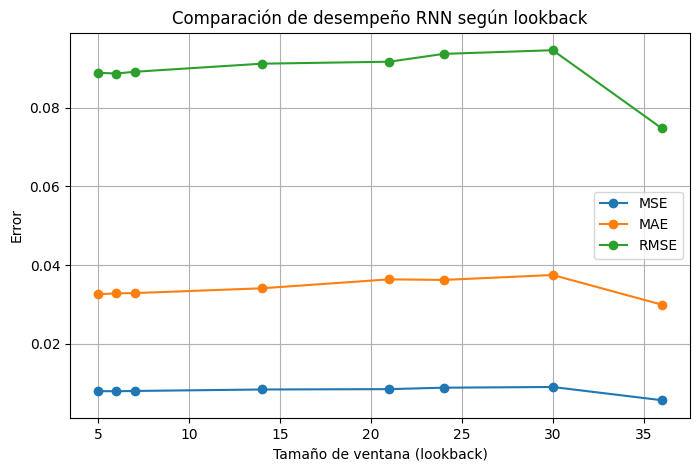

In [37]:
# ===============================================================
#  Visualización de resultados
# ===============================================================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

# --- Gráfico comparativo de errores
plt.figure(figsize=(8, 5))
plt.plot(results_df['Lookback'], results_df['MSE'], marker='o', label='MSE')
plt.plot(results_df['Lookback'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Lookback'], results_df['RMSE'], marker='o', label='RMSE')
plt.xlabel('Tamaño de ventana (lookback)')
plt.ylabel('Error')
plt.title('Comparación de desempeño RNN según lookback')
plt.legend()
plt.grid(True)
plt.show()

En general al evaluar los lookback en el modelo actual el que mejor desempeño nos referencia que la ventana de 36 dias para capturar los cambios del modelo, es decir que los resultados muestran que las ventanas más cortas (6–12 días) capturan mejor la variabilidad inmediata de la precipitación, mientras que las más largas (24–36 días) permiten representar patrones de acumulación y persistencia.

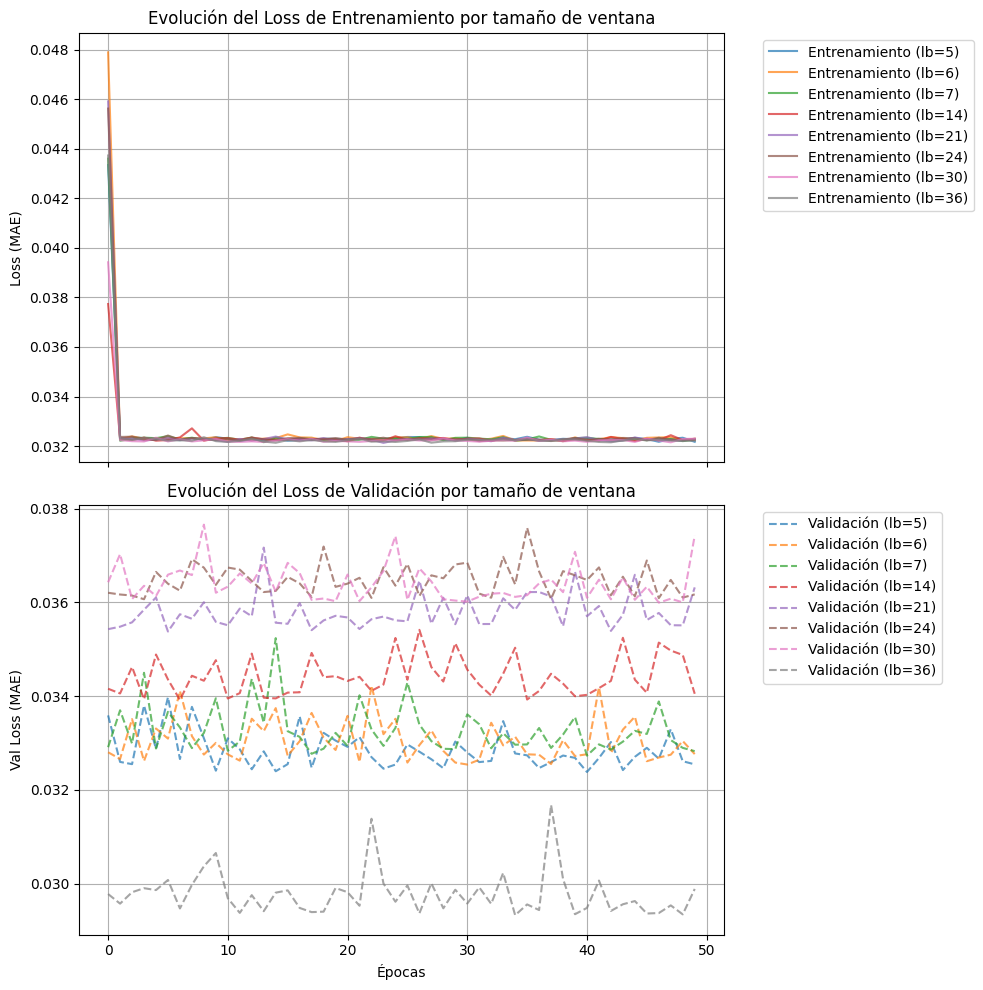

In [38]:
# ===============================================================
#  Gráfico de evolución del Loss (Train y Validación)
# ===============================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- Train Loss
for n_steps, history in histories.items():
    axes[0].plot(history.history['loss'], label=f'Entrenamiento (lb={n_steps})', alpha=0.7)
axes[0].set_title('Evolución del Loss de Entrenamiento por tamaño de ventana')
axes[0].set_ylabel('Loss (MAE)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Validation Loss
for n_steps, history in histories.items():
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Validación (lb={n_steps})', alpha=0.7)
axes[1].set_title('Evolución del Loss de Validación por tamaño de ventana')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Val Loss (MAE)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Con el primer grafico se observa que los modelos entrenados presentan una rapida convergencia en sus primeras epocas, donde se estabiliza lo que indica que logra identificar ciertos patrones

en el segundo se observa que el modelo en si tiene oportunides de mejora, ya que se ve osilaciones con pocos cambios, en la observcion de todos ellos el que tiene menor cambio de sus curvas es la ventana de 36 dias.


 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0  0.002532
1   0.0  0.002532
2   0.0  0.002532
3   0.0  0.002532
4   0.0  0.002532
5   0.0  0.002532
6   0.0  0.002532
7   0.0  0.002532
8   0.0  0.002532
9   0.0  0.002532


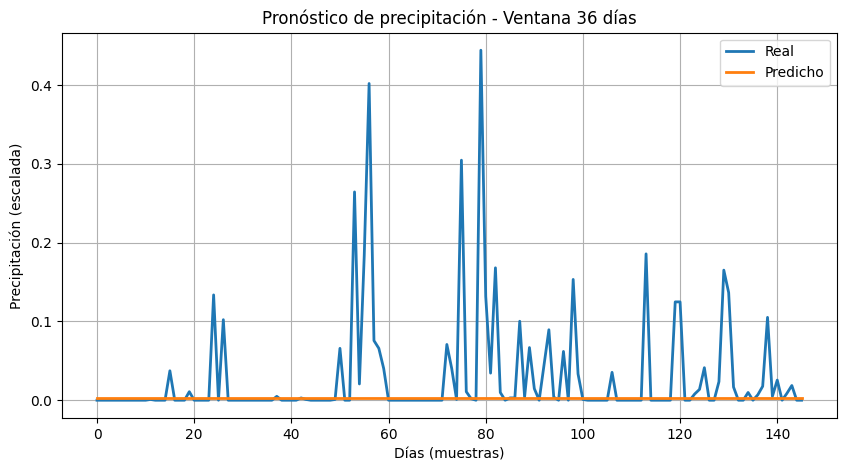

In [40]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

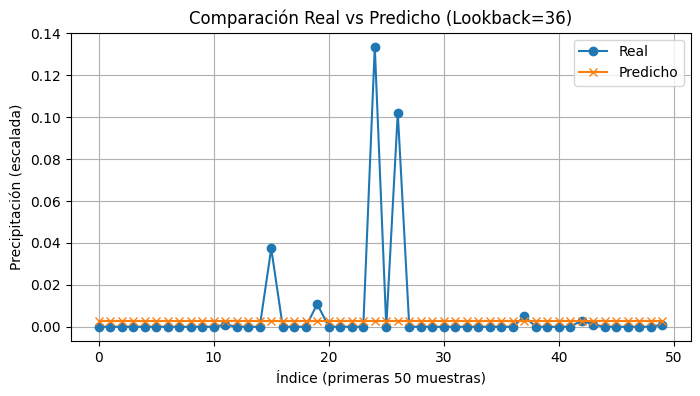

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(pred_df['Real'][:50].values, label='Real', marker='o')
plt.plot(pred_df['Predicho'][:50].values, label='Predicho', marker='x')
plt.title(f'Comparación Real vs Predicho (Lookback={best_lookback})')
plt.xlabel('Índice (primeras 50 muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

Sin embargo, los resultados del modelo indican que estas ventanas no presentan la mejor distribución, debido a que las precipitaciones diarias contienen una gran cantidad de valores cero. Esto sugiere la necesidad de capturar las tendencias de acumulación o persistencia en la variable objetivo (target).

Por ello, se ajustará el modelo para incluir una variable basada en la media móvil, con el fin de representar mejor estas dinámicas temporales.